# Model to ICEWS Events

In this analysis, I'm going to build a basic BDM model for the world based on COW alliance taus (with position = similarity to United States, to capture unipolarity) and see how predicted conflicts align with ICEWS events.

In [1]:
import copy
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, permutations


import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from negotiation_model import *
from bdm_agent import *
from bdm_replication import *

## Load Alliance Data

In [3]:
start_year = 2004

In [4]:
alliance_dyads = pd.read_csv("/Users/dmasad/Data/COW/Alliances/alliance_v4.1_by_dyad_yearly.csv")
alliance_dyads = alliance_dyads[alliance_dyads.year==start_year]
alliance_dyads["Alliance"] = 0
alliance_dyads.loc[(alliance_dyads.entente==1),"Alliance"] = 1
alliance_dyads.loc[(alliance_dyads.nonaggression==1),"Alliance"] = 2
alliance_dyads.loc[(alliance_dyads.neutrality==1),"Alliance"] = 3
alliance_dyads.loc[(alliance_dyads.defense==1),"Alliance"] = 4

In [5]:
ccode_to_name = {}
for key, val in alliance_dyads.groupby(["ccode1", "state_name1"]):
    ccode, name = key
    ccode_to_name[ccode] = name
for key, val in alliance_dyads.groupby(["ccode2", "state_name2"]):
    ccode, name = key
    ccode_to_name[ccode] = name

In [6]:
G = nx.Graph()
for i, row in alliance_dyads.iterrows():
    G.add_edge(row.state_name1, row.state_name2, weight=row.Alliance)

(-0.25, 8.25)

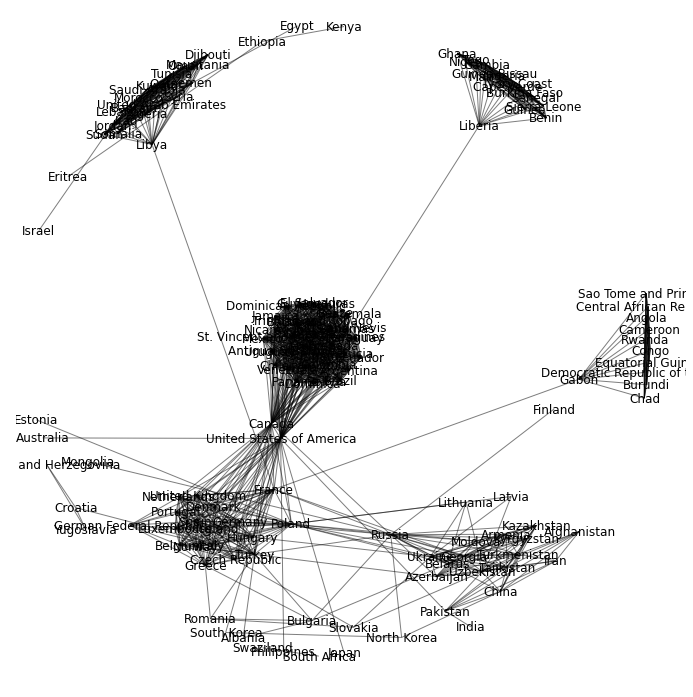

In [7]:
pos = nx.spring_layout(G, k=0.15, scale=8)

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')

#nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.5)
nx.draw_networkx_labels(G, pos=pos)

ax.set_xlim(-0.25, 8.25)
ax.set_ylim(-0.25, 8.25)

In [8]:
names = {node: i for i, node in enumerate(G.nodes())}
mat = nx.to_numpy_matrix(G)

def get_tau(state_1, state_2, p_val=False):
    try:
        n1 = names[state_1]
        n2 = names[state_2]
        v1 = mat[n1]
        v2 = mat[n2]
        tau = scipy.stats.kendalltau(v1, v2)
    except:
        tau = (0, 0)
    if p_val:
        return tau
    else:
        return tau[0]

In [9]:
# How to normalize positions
positions = [get_tau("United States of America", actor)
             for actor in G.nodes()]
max_pos = max(positions)
min_pos = min(positions)
print(max_pos)
print(min_pos)

1.0
-0.324820421265


## NMC Data

In [10]:
nmc = pd.read_csv("/Users/dmasad/Data/COW/NMC_v4_0.csv")
nmc = nmc[nmc.year==start_year].copy()

In [11]:
# Add full names
system_members = pd.read_csv("/Users/dmasad/Data/COW/SystemMembership2011/states2011.csv")
system_members = system_members.drop_duplicates("ccode")
nmc = nmc.merge(system_members[["ccode", "statenme"]], how='left', on="ccode")

In [12]:
for node in G.nodes():
    if len(nmc[nmc.statenme==node]) == 0:
        print(node)

German Federal Republic


In [13]:
nmc[nmc.statenme=="Germany"]

,stateabb,ccode,year,irst,milex,milper,pec,tpop,upop,cinc,version,statenme
47,GMY,255,2004,46374,38263000,284,1181726,82501,25405,0.026612,4,Germany


# Build Model

In [14]:
# Build a dictionary of Actor data
ActorData = namedtuple("ActorData", ["name", "position", "capability"])
actor_data = defaultdict(ActorData)

In [15]:
for actor in G.nodes():
    position = get_tau("United States of America", actor, p_val=False)
    position = (position + abs(min_pos))/(max_pos - min_pos)
    name = actor if actor != "German Federal Republic" else "Germany"
    capability = nmc[nmc.statenme==name].cinc.values[0]
    actor_data[name] = ActorData(name, position, capability)

### Top 50 agents

In [16]:
top_actors = nmc.sort("cinc", ascending=False).head(50)["statenme"].unique()

In [17]:
top_actors

array(['China', 'United States of America', 'India', 'Japan', 'Russia',
       'Germany', 'Brazil', 'South Korea', 'United Kingdom', 'France',
       'Italy', 'Ukraine', 'Turkey', 'Pakistan', 'Indonesia',
       'North Korea', 'Iran', 'Mexico', 'Spain', 'Canada', 'Egypt',
       'Saudi Arabia', 'Taiwan', 'Vietnam', 'Bangladesh', 'Thailand',
       'Nigeria', 'Myanmar', 'Poland', 'Australia', 'South Africa',
       'Netherlands', 'Colombia', 'Iraq', 'Philippines', 'Sweden',
       'Algeria', 'Argentina', 'Belgium', 'Venezuela', 'Syria', 'Morocco',
       'Malaysia', 'Ethiopia', 'Greece', 'Israel', 'Romania',
       'Democratic Republic of the Congo', 'Kazakhstan', 'Chile'], dtype=object)

In [18]:
top_actor_dicts = []
for key in top_actors:
    if key in actor_data:
        a = actor_data[key]
        top_actor_dicts.append({"Name": a.name, 
                                "Position": a.position,
                                "Capability": a.capability})
    else:
        top_actor_dicts.append({"Name": key, 
                                "Position": None,
                                "Capability": nmc[nmc.statenme==key].cinc.values[0]})
actor_df = pd.DataFrame(top_actor_dicts)
actor_df = actor_df[["Name", "Position", "Capability"]]
actor_df.sort("Name", inplace=True)

In [19]:
print(actor_df.to_latex(float_format=lambda x: "{:.3f}".format(x)))

\begin{tabular}{llrr}
\toprule
{} &                              Name &  Position &  Capability \\
\midrule
36 &                           Algeria &     0.007 &       0.005 \\
37 &                         Argentina &     0.732 &       0.005 \\
29 &                         Australia &     0.192 &       0.007 \\
24 &                        Bangladesh &       nan &       0.008 \\
38 &                           Belgium &     0.548 &       0.005 \\
6  &                            Brazil &     0.734 &       0.024 \\
19 &                            Canada &     0.907 &       0.011 \\
49 &                             Chile &     0.732 &       0.003 \\
0  &                             China &     0.115 &       0.183 \\
32 &                          Colombia &     0.734 &       0.006 \\
47 &  Democratic Republic of the Congo &     0.072 &       0.004 \\
20 &                             Egypt &     0.192 &       0.009 \\
43 &                          Ethiopia &     0.170 &       0.004 \\
9  &    

In [21]:
len(actor_df)

50

In [22]:
actor_df.to_csv("ICEWS_2004_agents.csv", index=False)

### Multiple iterations

In [ ]:
agents = []
for name in top_actors:
    if name in actor_data:
        actor = actor_data[name]
        new_agent = BDMActor(actor.name, actor.capability, actor.position, 1)
    else:
        capability = nmc[nmc.statenme==name].cinc.values[0]
        pos = 0.5 + random.normalvariate(0, 0.1)
        new_agent = BDMActor(name, capability, 0.5, 1)

    new_agent.decision_model.Q = 0.5
    new_agent.decision_model.T = 0.5
    agents.append(new_agent)
    
model = Real_Negotiation_Model(agents)